<a href="https://colab.research.google.com/github/aquangnguyen1992/Advanced_Data_Science_Capstone/blob/Old_model_Aug_18/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Get the dataset from Kaggle***

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle competitions download -c ieee-fraud-detection
!unzip \*.zip  && rm *.zip

# ***Analyzing the dataset and doing the cleansing***

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os
import tensorflow as tf

In [3]:
os.chdir("/content")
dataset_transaction = pd.read_csv('train_transaction.csv')
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
dataset_identity = pd.read_csv('train_identity.csv')
dataset_identity.head(5)
saved_columns= np.array(dataset_identity.columns)

In [ ]:
dataset_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [ ]:
dataset_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [ ]:
#Data transaction
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_transaction = []
removed = 0
for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_transaction[column].values))
  if count_NaN/len(dataset_transaction[column].values) > 0.9:
    to_remove_NaN_dataset_transaction.append(column)
    dataset_transaction.pop(column)
    removed += 1
print("Removed: " + str(removed))

In [ ]:
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_transaction = []
removed = 0
for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_transaction[column].values))
  if count_NaN/len(dataset_transaction[column].values) > 0.9:
    to_remove_NaN_dataset_transaction.append(column)

for column in to_remove_NaN_dataset_transaction:
  print(column)
  data_test = dataset_transaction[column]
  indices = np.where(np.isnan(data_test) == False)[0]
  data_b = dataset_transaction.iloc[indices]
  indices_fraud = np.where(data_b['isFraud'] == 1)[0]
  print("Not NaN:" + str(len(indices)) + "; " + str(len(indices_fraud)) + "; " + str(len(indices_fraud)/len(indices)*100))

  indices = np.where(np.isnan(data_test) == True)[0]
  data_b = dataset_transaction.iloc[indices]
  indices_fraud = np.where(data_b['isFraud'] == 1)[0]
  print("% NaN: " + str(len(indices)/len(data_test)*100))
  print("NaN:" + str(len(indices)) + "; " + str(len(indices_fraud)) + "; " + str(len(indices_fraud)/len(indices)*100))


In [ ]:
# Dataset Identity
float_columns = dataset_identity.columns[np.where(dataset_identity.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_identity = []
removed = 0
for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_identity[column].values))
  if count_NaN/len(dataset_identity[column]) > 0.75:
    to_remove_NaN_dataset_identity.append(column)
    dataset_identity.pop(column)
    removed += 1
print("Removed: " + str(removed))


In [5]:
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  dataset_identity.pop(column)

to_remove_id_2 = ["TransactionDT"]
for column in to_remove_id_2:
  dataset_transaction.pop(column)

In [6]:
merged_data = pd.merge(left=dataset_transaction, right=dataset_identity, how='left', left_on='TransactionID', right_on='TransactionID')

dataset_transaction = None
dataset_identity = None
merged_data.shape

(590540, 429)

In [7]:
################################# Test ##########################################
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv', names=saved_columns, header=0)

for column in to_remove_id:
  test_identity.pop(column)

test_merged_data = pd.merge(left=test_transaction, right=test_identity, how='left', left_on='TransactionID', right_on='TransactionID')

TransactionID = test_merged_data.pop('TransactionID')
test_transaction = None
test_identity = None
test_merged_data.shape

################################################################################

(506691, 428)

In [ ]:
merged_data.tail(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Check NaN, Null, and OneHotEncoding**

In [8]:
dataset_transaction = copy.copy(merged_data)
merged_data = None
dataset_identity = None

float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

skip_obj_colums = ['']
cache = dict()
print(len(float_columns), len(int_columns), len(obj_columns))

399 1 27


In [ ]:
'''filled_nan = dataset_transaction['R_emaildomain'].fillna('NaN')
a = filled_nan.values
all_data = np.unique(a, return_index=True)

isfraud = dataset_transaction['isFraud'].values
for each_data in all_data[0]:
  true_count = np.sum(isfraud[a == each_data])
  all_count = len(isfraud[a == each_data])
  print(each_data, true_count, all_count, true_count*1.0/all_count)'''

NaN 9436 453249 0.02081857875031164
aim.com 1 36 0.027777777777777776
anonymous.com 598 20529 0.02912952408787569
aol.com 129 3701 0.03485544447446636
att.net 0 430 0.0
bellsouth.net 2 422 0.004739336492890996
cableone.net 0 27 0.0
centurylink.net 0 12 0.0
cfl.rr.com 0 37 0.0
charter.net 5 127 0.03937007874015748
comcast.net 21 1812 0.011589403973509934
cox.net 11 459 0.023965141612200435
earthlink.net 6 79 0.0759493670886076
embarqmail.com 0 68 0.0
frontier.com 0 52 0.0
frontiernet.net 0 14 0.0
gmail 0 95 0.0
gmail.com 6811 57147 0.11918385917021015
gmx.de 0 147 0.0
hotmail.co.uk 0 105 0.0
hotmail.com 2140 27509 0.07779272238176596
hotmail.de 0 42 0.0
hotmail.es 20 292 0.0684931506849315
hotmail.fr 0 293 0.0
icloud.com 180 1398 0.12875536480686695
juno.com 0 53 0.0
live.com 38 762 0.049868766404199474
live.com.mx 44 754 0.058355437665782495
live.fr 0 55 0.0
mac.com 2 218 0.009174311926605505
mail.com 46 122 0.3770491803278688
me.com 11 556 0.019784172661870502
msn.com 1 852 0.00117370

In [9]:
def normalization_data(X, indices, max_test, min_test):
  X_out = copy.copy(X)
  X_temp = X[indices]
  #max_X = np.max([np.max(X_temp), max_test])
  #min_X = np.min([np.min(X_temp), min_test])
  max_X = np.max(X_temp)
  min_X = np.min(X_temp)
  mean_X = np.mean(X_temp)
  median_X = np.median(X_temp)

  #if np.sum(np.where(np.isnan(X_out))[0]) > 0.8*len(X_out): # So too many NAN
  #  X_out.iloc[np.where(np.isnan(X_out))[0]] = min_X
  #else:
  #  X_out.iloc[np.where(np.isnan(X_out))[0]] = median_X
  X_out.iloc[np.where(np.isnan(X_out))[0]] = median_X
  X_out = (X_out - min_X)/(max_X - min_X) # So from 0 to 1

  return min_X, max_X, mean_X, median_X, X_out.astype('float32')

In [ ]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,32.0,match_status:2,T,F,T,T,mobile


In [10]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# Task 3: Remove the irrelevant columns
out = ['isFraud']

for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float32')

  # Code the NaN column for every features
  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  out.append(column + "_NaN_Code")
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(X) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], cache[column+'_median'], dataset_transaction[column] = normalization_data(X, indices, np.max(test_merged_data[column]), np.min(test_merged_data[column]))
  dataset_transaction[column].astype('float32')
print(out)

['isFraud', 'TransactionAmt_NaN_Code', 'card2_NaN_Code', 'card3_NaN_Code', 'card5_NaN_Code', 'addr1_NaN_Code', 'addr2_NaN_Code', 'dist1_NaN_Code', 'dist2_NaN_Code', 'C1_NaN_Code', 'C2_NaN_Code', 'C3_NaN_Code', 'C4_NaN_Code', 'C5_NaN_Code', 'C6_NaN_Code', 'C7_NaN_Code', 'C8_NaN_Code', 'C9_NaN_Code', 'C10_NaN_Code', 'C11_NaN_Code', 'C12_NaN_Code', 'C13_NaN_Code', 'C14_NaN_Code', 'D1_NaN_Code', 'D2_NaN_Code', 'D3_NaN_Code', 'D4_NaN_Code', 'D5_NaN_Code', 'D6_NaN_Code', 'D7_NaN_Code', 'D8_NaN_Code', 'D9_NaN_Code', 'D10_NaN_Code', 'D11_NaN_Code', 'D12_NaN_Code', 'D13_NaN_Code', 'D14_NaN_Code', 'D15_NaN_Code', 'V1_NaN_Code', 'V2_NaN_Code', 'V3_NaN_Code', 'V4_NaN_Code', 'V5_NaN_Code', 'V6_NaN_Code', 'V7_NaN_Code', 'V8_NaN_Code', 'V9_NaN_Code', 'V10_NaN_Code', 'V11_NaN_Code', 'V12_NaN_Code', 'V13_NaN_Code', 'V14_NaN_Code', 'V15_NaN_Code', 'V16_NaN_Code', 'V17_NaN_Code', 'V18_NaN_Code', 'V19_NaN_Code', 'V20_NaN_Code', 'V21_NaN_Code', 'V22_NaN_Code', 'V23_NaN_Code', 'V24_NaN_Code', 'V25_NaN_Code'

In [ ]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V323_NaN_Code,V324_NaN_Code,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code,id_01_NaN_Code,id_02_NaN_Code,id_03_NaN_Code,id_04_NaN_Code,id_05_NaN_Code,id_06_NaN_Code,id_07_NaN_Code,id_08_NaN_Code,id_09_NaN_Code,id_10_NaN_Code,id_11_NaN_Code,id_13_NaN_Code,id_14_NaN_Code,id_17_NaN_Code,id_18_NaN_Code,id_19_NaN_Code,id_20_NaN_Code,id_21_NaN_Code,id_22_NaN_Code,id_24_NaN_Code,id_25_NaN_Code,id_26_NaN_Code,id_32_NaN_Code
0,2987000,0,68.5,W,13926,361.0,150.0,discover,142.0,credit,315.0,87.0,19.0,37.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666666,13.0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2987001,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,37.0,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666666,0.0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2987002,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,37.0,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666666,0.0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2987003,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,8.0,37.0,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,0.0,37.875,0.666666,84.0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2987004,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,8.0,37.0,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,0.0,0.0,37.875,0.666666,15.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,1,1,1,1,1,0


In [11]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('float32')

  # Code the NaN feature
  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  out.append(column + "_NaN_Code")
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], cache[column+'_median'], dataset_transaction[column] = normalization_data(X, indices, np.max(test_merged_data[column]), np.min(test_merged_data[column]))

print(out)

['isFraud', 'TransactionAmt_NaN_Code', 'card2_NaN_Code', 'card3_NaN_Code', 'card5_NaN_Code', 'addr1_NaN_Code', 'addr2_NaN_Code', 'dist1_NaN_Code', 'dist2_NaN_Code', 'C1_NaN_Code', 'C2_NaN_Code', 'C3_NaN_Code', 'C4_NaN_Code', 'C5_NaN_Code', 'C6_NaN_Code', 'C7_NaN_Code', 'C8_NaN_Code', 'C9_NaN_Code', 'C10_NaN_Code', 'C11_NaN_Code', 'C12_NaN_Code', 'C13_NaN_Code', 'C14_NaN_Code', 'D1_NaN_Code', 'D2_NaN_Code', 'D3_NaN_Code', 'D4_NaN_Code', 'D5_NaN_Code', 'D6_NaN_Code', 'D7_NaN_Code', 'D8_NaN_Code', 'D9_NaN_Code', 'D10_NaN_Code', 'D11_NaN_Code', 'D12_NaN_Code', 'D13_NaN_Code', 'D14_NaN_Code', 'D15_NaN_Code', 'V1_NaN_Code', 'V2_NaN_Code', 'V3_NaN_Code', 'V4_NaN_Code', 'V5_NaN_Code', 'V6_NaN_Code', 'V7_NaN_Code', 'V8_NaN_Code', 'V9_NaN_Code', 'V10_NaN_Code', 'V11_NaN_Code', 'V12_NaN_Code', 'V13_NaN_Code', 'V14_NaN_Code', 'V15_NaN_Code', 'V16_NaN_Code', 'V17_NaN_Code', 'V18_NaN_Code', 'V19_NaN_Code', 'V20_NaN_Code', 'V21_NaN_Code', 'V22_NaN_Code', 'V23_NaN_Code', 'V24_NaN_Code', 'V25_NaN_Code'

In [ ]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code,id_01_NaN_Code,id_02_NaN_Code,id_03_NaN_Code,id_04_NaN_Code,id_05_NaN_Code,id_06_NaN_Code,id_07_NaN_Code,id_08_NaN_Code,id_09_NaN_Code,id_10_NaN_Code,id_11_NaN_Code,id_13_NaN_Code,id_14_NaN_Code,id_17_NaN_Code,id_18_NaN_Code,id_19_NaN_Code,id_20_NaN_Code,id_21_NaN_Code,id_22_NaN_Code,id_24_NaN_Code,id_25_NaN_Code,id_26_NaN_Code,id_32_NaN_Code,TransactionDT_NaN_Code,card1_NaN_Code
0,2987000,0,0.000000,0.002144,W,0.743164,0.521973,0.378906,discover,0.306641,credit,0.488525,0.836914,0.001847,0.003183,NaN,NaN,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.001748,0.000000,0.000628,0.0,0.000343,0.0007,0.021835,0.151367,0.012085,0.122009,0.009193,0.070679,0.0,0.018661,0.695801,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
1,2987001,0,0.000000,0.000907,W,0.100891,0.607910,0.378906,mastercard,0.014595,credit,0.511230,0.836914,0.000778,0.003183,gmail.com,NaN,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.000000,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.151367,0.007435,0.100586,0.009193,0.070679,0.0,0.018661,0.695801,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
2,2987002,0,0.000002,0.001847,W,0.210571,0.779785,0.378906,visa,0.481689,debit,0.522949,0.836914,0.027908,0.003183,outlook.com,NaN,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.001748,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.151367,0.007435,0.100586,0.009193,0.070679,0.0,0.018661,0.695801,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
3,2987003,0,0.000003,0.001565,W,0.984863,0.934082,0.378906,mastercard,0.124084,debit,0.854492,0.836914,0.000778,0.003183,yahoo.com,NaN,0.000427,0.000879,0.0,0.0,0.0,0.001776,0.0,0.0000,0.001748,0.000000,0.000314,0.0,0.008568,0.0007,0.174683,0.174683,0.000000,0.178101,0.000000,0.070679,0.0,0.018661,0.695801,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
4,2987004,0,0.000003,0.001565,H,0.201050,0.828125,0.378906,mastercard,0.014595,credit,0.727051,0.836914,0.000778,0.003183,gmail.com,NaN,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0003,0.000000,0.000307,0.000314,0.0,0.000343,0.0007,0.000000,0.151367,0.007435,0.122009,0.009193,0.070679,0.0,0.018661,0.695801,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,1,1,1,1,1,0,0,0


In [12]:
from sklearn.preprocessing import OneHotEncoder

encoded_column = 0
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)
  cache[column] = dataset_transaction[column].values.reshape(-1,1)
  encoded_column += len(pd_encoded.columns)
  out.extend(pd_encoded.columns.to_list())

print("Encoded columns: " + str(encoded_column))
for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass

print(out)

Encoded columns: 207
['isFraud', 'TransactionAmt_NaN_Code', 'card2_NaN_Code', 'card3_NaN_Code', 'card5_NaN_Code', 'addr1_NaN_Code', 'addr2_NaN_Code', 'dist1_NaN_Code', 'dist2_NaN_Code', 'C1_NaN_Code', 'C2_NaN_Code', 'C3_NaN_Code', 'C4_NaN_Code', 'C5_NaN_Code', 'C6_NaN_Code', 'C7_NaN_Code', 'C8_NaN_Code', 'C9_NaN_Code', 'C10_NaN_Code', 'C11_NaN_Code', 'C12_NaN_Code', 'C13_NaN_Code', 'C14_NaN_Code', 'D1_NaN_Code', 'D2_NaN_Code', 'D3_NaN_Code', 'D4_NaN_Code', 'D5_NaN_Code', 'D6_NaN_Code', 'D7_NaN_Code', 'D8_NaN_Code', 'D9_NaN_Code', 'D10_NaN_Code', 'D11_NaN_Code', 'D12_NaN_Code', 'D13_NaN_Code', 'D14_NaN_Code', 'D15_NaN_Code', 'V1_NaN_Code', 'V2_NaN_Code', 'V3_NaN_Code', 'V4_NaN_Code', 'V5_NaN_Code', 'V6_NaN_Code', 'V7_NaN_Code', 'V8_NaN_Code', 'V9_NaN_Code', 'V10_NaN_Code', 'V11_NaN_Code', 'V12_NaN_Code', 'V13_NaN_Code', 'V14_NaN_Code', 'V15_NaN_Code', 'V16_NaN_Code', 'V17_NaN_Code', 'V18_NaN_Code', 'V19_NaN_Code', 'V20_NaN_Code', 'V21_NaN_Code', 'V22_NaN_Code', 'V23_NaN_Code', 'V24_NaN_

In [ ]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,2987000,0,0.000000,0.002144,0.743164,NaN,0.378906,0.306641,0.488525,0.836914,0.001847,NaN,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.001748,0.000000,0.000628,0.0,0.000343,0.0007,0.021835,NaN,0.012085,NaN,NaN,NaN,NaN,NaN,NaN,0.011917,0.070496,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,2987001,0,0.000000,0.000907,0.100891,0.607910,0.378906,0.014595,0.511230,0.836914,NaN,NaN,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.000000,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,NaN,NaN,0.100586,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,2987002,0,0.000002,0.001847,0.210571,0.779785,0.378906,0.481689,0.522949,0.836914,0.027908,NaN,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.001748,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,NaN,NaN,0.100586,NaN,NaN,NaN,NaN,NaN,0.000000,0.393066,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,2987003,0,0.000003,0.001565,0.984863,0.934082,0.378906,0.124084,0.854492,0.836914,NaN,NaN,0.000427,0.000879,0.0,0.0,0.0,0.001776,0.0,0.0000,0.001748,0.000000,0.000314,0.0,0.008568,0.0007,0.174683,0.174683,0.000000,0.178101,0.0,NaN,NaN,NaN,NaN,0.076965,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,2987004,0,0.000003,0.001565,0.201050,0.828125,0.378906,0.014595,0.727051,0.836914,NaN,NaN,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0003,0.000000,0.000307,0.000314,0.0,0.000343,0.0007,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [ ]:
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


**Apply Seaborn to preliminary analyze the dataset**

In [ ]:
'''out = ['isFraud']
for column in dataset_transaction.columns:
  if column.find('R_emaildomain') != -1:
    out.append(column)
  if column.find('P_emaildomain') != -1:
    out.append(column)
  if column.find('id_') != -1:
    out.append(column)
  if column.find('card') != -1:
    out.append(column)
  if column.find('addr') != -1:
    out.append(column)'''
print(out, len(out))

['isFraud', 'TransactionAmt_NaN_Code', 'card2_NaN_Code', 'card3_NaN_Code', 'card5_NaN_Code', 'addr1_NaN_Code', 'addr2_NaN_Code', 'dist1_NaN_Code', 'dist2_NaN_Code', 'C1_NaN_Code', 'C2_NaN_Code', 'C3_NaN_Code', 'C4_NaN_Code', 'C5_NaN_Code', 'C6_NaN_Code', 'C7_NaN_Code', 'C8_NaN_Code', 'C9_NaN_Code', 'C10_NaN_Code', 'C11_NaN_Code', 'C12_NaN_Code', 'C13_NaN_Code', 'C14_NaN_Code', 'D1_NaN_Code', 'D2_NaN_Code', 'D3_NaN_Code', 'D4_NaN_Code', 'D5_NaN_Code', 'D6_NaN_Code', 'D7_NaN_Code', 'D8_NaN_Code', 'D9_NaN_Code', 'D10_NaN_Code', 'D11_NaN_Code', 'D12_NaN_Code', 'D13_NaN_Code', 'D14_NaN_Code', 'D15_NaN_Code', 'V1_NaN_Code', 'V2_NaN_Code', 'V3_NaN_Code', 'V4_NaN_Code', 'V5_NaN_Code', 'V6_NaN_Code', 'V7_NaN_Code', 'V8_NaN_Code', 'V9_NaN_Code', 'V10_NaN_Code', 'V11_NaN_Code', 'V12_NaN_Code', 'V13_NaN_Code', 'V14_NaN_Code', 'V15_NaN_Code', 'V16_NaN_Code', 'V17_NaN_Code', 'V18_NaN_Code', 'V19_NaN_Code', 'V20_NaN_Code', 'V21_NaN_Code', 'V22_NaN_Code', 'V23_NaN_Code', 'V24_NaN_Code', 'V25_NaN_Code'

In [ ]:
#columns_to_analyze = ['isFraud', 'DeviceType_0', 'DeviceType_1', 'DeviceType_2', 'id_15_0', 'id_15_1', 'id_15_2', 'id_15_3']#, 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3', 'P_emaildomain_4', 'addr1', 'addr2', 'dist1', 'dist2', 'card1', 'card2', 'card3']
columns_to_analyze = out

analyzing_data = dataset_transaction[columns_to_analyze]

In [ ]:
corr = analyzing_data.corr()
to_display = False

if to_display:
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Remove the weak correlation features
col = corr.columns
is_fraud = np.where(col=='isFraud')[0][0]
col = col.to_list()
col.pop(is_fraud)
to_remove = []
for each_col in col:
  if abs(corr['isFraud'][each_col]) < 0.01: # Weak correlation
    to_remove.append(each_col)
    a = dataset_transaction.pop(each_col)
print(len(to_remove))
analyzing_data = None


dataset_transaction.head(5)

228


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,M8_2,M9_1,M9_2,id_12_0,id_12_1,id_12_2,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_2,id_23_3,id_27_0,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_3,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,2987000,0,0.000000,0.002144,0.743164,0.000000,0.378906,0.306641,0.488525,0.836914,0.001847,0.0,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.001748,0.000000,0.000628,0.0,0.000343,0.0007,0.021835,0.000000,0.012085,0.000000,0.0,0.0,0.0,0.0,0.0,0.011917,0.070496,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
1,2987001,0,0.000000,0.000907,0.100891,0.607910,0.378906,0.014595,0.511230,0.836914,0.000000,0.0,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.000000,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.000000,0.000000,0.100586,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
2,2987002,0,0.000002,0.001847,0.210571,0.779785,0.378906,0.481689,0.522949,0.836914,0.027908,0.0,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.001748,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.000000,0.000000,0.100586,0.0,0.0,0.0,0.0,0.0,0.000000,0.393066,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
3,2987003,0,0.000003,0.001565,0.984863,0.934082,0.378906,0.124084,0.854492,0.836914,0.000000,0.0,0.000427,0.000879,0.0,0.0,0.0,0.001776,0.0,0.0000,0.001748,0.000000,0.000314,0.0,0.008568,0.0007,0.174683,0.174683,0.000000,0.178101,0.0,0.0,0.0,0.0,0.0,0.076965,0.000000,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
4,2987004,0,0.000003,0.001565,0.201050,0.828125,0.378906,0.014595,0.727051,0.836914,0.000000,0.0,0.000214,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0003,0.000000,0.000307,0.000314,0.0,0.000343,0.0007,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1


In [ ]:
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


# ***Creat the train/val dataset***

In [13]:
# Create a copy
dataset = copy.copy(dataset_transaction)

# Remove the irrelevant columns
dataset.pop('TransactionID')
dataset.head(5)

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,0,0.002137,0.743044,0.522,0.381679,0.306569,0.488636,0.836957,0.001847,0.003183,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.004762,0.000000,0.000627,0.0,0.000343,0.0007,0.021875,0.151562,0.015873,0.149344,0.01221,0.08682,0.0,0.022178,0.695652,0.014840,0.091286,0.113543,0.0,0.180205,0.086279,1.0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,0,0.000900,0.100885,0.608,0.381679,0.014599,0.511364,0.836957,0.000778,0.003183,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.000000,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.151562,0.009768,0.123108,0.01221,0.08682,0.0,0.022178,0.695652,0.000000,0.132780,0.113543,0.0,0.180205,0.086279,1.0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,0,0.001840,0.210566,0.780,0.381679,0.481752,0.522727,0.836957,0.027902,0.003183,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.004762,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.151562,0.009768,0.123108,0.01221,0.08682,0.0,0.022178,0.695652,0.000000,0.508990,0.113543,0.0,0.180205,0.413721,1.0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,0,0.001558,0.984824,0.934,0.381679,0.124088,0.854545,0.836957,0.000778,0.003183,0.000427,0.000879,0.0,0.0,0.0,0.001775,0.0,0.0000,0.004762,0.000000,0.000314,0.0,0.008568,0.0007,0.175000,0.175000,0.000000,0.217962,0.00000,0.08682,0.0,0.022178,0.695652,0.095890,0.132780,0.113543,0.0,0.180205,0.201663,1.0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,0,0.001558,0.201023,0.828,0.381679,0.014599,0.727273,0.836957,0.000778,0.003183,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0003,0.000000,0.000307,0.000314,0.0,0.000343,0.0007,0.000000,0.151562,0.009768,0.149344,0.01221,0.08682,0.0,0.022178,0.695652,0.017123,0.132780,0.113543,0.0,0.180205,0.140333,1.0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [14]:
from sklearn.model_selection import train_test_split

Y_train = dataset['isFraud']
dataset.pop('isFraud')
X_train = dataset

Percentage of Fraud: 3.5%


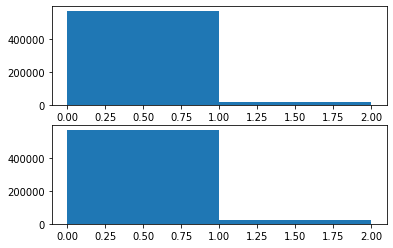

In [15]:
plt.subplot(211)
plt.hist(Y_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_train, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

In [16]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
PCA_size = int(0.5*X_train.shape[0])
svd.fit(X_train[:PCA_size].values)
print(svd.explained_variance_ratio_.sum())

X_transformed = svd.transform(X_train)
print(X_train.shape, X_transformed.shape)

0.99945307
(590540, 1007) (590540, 200)


In [17]:
X_train = None
dataset = None
X_transformed_normalized = copy.copy(X_transformed)
X_transformed = None
print(X_transformed_normalized.shape)

(590540, 200)


In [ ]:
from sklearn import preprocessing
X_train = None
dataset = None

scaler = preprocessing.MinMaxScaler().fit(X_transformed)
X_transformed_normalized = scaler.transform(X_transformed)

X_transformed = None

**Downsampling and upsampling**

In [18]:
downsampling_factor = 1
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
#indices_test = [i for i in range(len(indices_0_new)) if i not in indices]
indices_0_train = indices_0_new[indices]
#indices_0_test = indices_0_new[indices_test]
indices_0_test = np.delete(indices_0_new, indices)
print(indices_0_train.shape, indices_0_test.shape)

(569877, 1) (0,)


In [ ]:
'''downsampling_factor = 2
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
indices_0_new = indices_0_new[indices]

print(indices_0_new.shape)'''

upsampling_factor = 1
indices_1_new = indices_1
for i in range(upsampling_factor):
  indices_1_new = np.concatenate((indices_1_new, indices_1), axis=0)

indices_0_new = np.concatenate((indices_1_new, indices_0_train), axis=0)

indices_0_new = tf.random.shuffle(indices_0_new)

X_new = np.array(X_train)[indices_0_new]
Y_new = np.array(Y_train)[indices_0_new]

X_test_2 = np.array(X_train)[indices_0_test]
Y_test_2 = np.array(Y_train)[indices_0_test]

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.01)

X_to_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2]))
Y_to_train = np.squeeze(Y_train, axis=1)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2]))
Y_test = np.squeeze(Y_test, axis=1)

#X_test_2 = np.squeeze(X_test_2, axis=1)
#Y_test_2 = np.squeeze(Y_test_2, axis=1)

print(X_to_train.shape, X_test.shape, X_test_2.shape, Y_test_2.shape)

In [19]:
# New train_test split, the points is to have all of the 1 labels in training
# Split some of the 0 labels in train/test

train_test_split_factor = 0.01
test_0_indices = np.arange(0,len(indices_0_train), int(1/train_test_split_factor))
test_indices = indices_0_new[test_0_indices]
test_indices = np.squeeze(test_indices, axis=1)
train_indices = np.delete(indices_0_new, test_0_indices)

print(test_indices.shape, train_indices.shape)

test_1_indices = np.arange(0, len(indices_1), int(1/(train_test_split_factor*1)))
test_indices = np.concatenate((test_indices, np.squeeze(indices_1[test_1_indices], axis=1)), axis=0)
train_indices = np.concatenate((train_indices, np.squeeze(indices_1, axis=1)), axis=0)

train_indices = tf.random.shuffle(train_indices)
test_indices = tf.random.shuffle(test_indices)

# Create the X_train, X_test, Y_train, Y_test
X_to_train = X_transformed_normalized[train_indices]
Y_to_train = Y_train.iloc[train_indices]

X_test = X_transformed_normalized[test_indices]
Y_test = Y_train.iloc[test_indices]

print(X_to_train.shape, Y_to_train.shape)
X_transformed_normalized = None


(5699,) (564178,)
(584841, 200) (584841,)


In [ ]:
from imblearn.over_sampling import SMOTE

train_indices = None
test_indices = None
test_0_indices = None
test_1_indices = None

sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X_to_train, Y_to_train)
print(X_res.shape, Y_res.shape)

X_to_train = None
Y_to_train = None


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(1025778, 100) (1025778,)


In [ ]:
# New solution for autoencoder
'''train_test_split_factor = 0.01
test_0_indices = np.arange(0,len(indices_0_train), int(1/train_test_split_factor))
test_indices = indices_0_new[test_0_indices]
test_indices = np.squeeze(test_indices, axis=1)
train_indices = np.delete(indices_0_new, test_0_indices)

print(test_indices.shape, train_indices.shape)

test_indices = np.concatenate((test_indices, np.squeeze(indices_1, axis=1)), axis=0)
train_indices = train_indices

train_indices = tf.random.shuffle(train_indices)
test_indices = tf.random.shuffle(test_indices)

# Create the X_train, X_test, Y_train, Y_test
X_to_train = X_train.iloc[train_indices]
Y_to_train = Y_train.iloc[train_indices]

X_test = X_train.iloc[test_indices]
Y_test = Y_train.iloc[test_indices]

X_test_2 = copy.copy(X_train)
Y_test_2 = copy.copy(Y_train)

print(X_to_train.shape, X_test.shape, X_test_2.shape)'''

(5699,) (564178,)
(564178, 608) (26362, 608) (590540, 608)


**Check the imbalane of the train/test dataset**

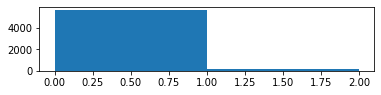

In [20]:
X_new = None
Y_new = None
test_merged_data = None

#plt.subplot(311)
#plt.hist(Y_to_train, bins=[0,1,2])

plt.subplot(312)
plt.hist(Y_test, bins=[0,1,2])

#plt.subplot(313)
#plt.hist(Y_res, bins=[0,1,2])

X_train = None
Y_train = None
X = None
Y = None

fraud_count = np.unique(Y_test, return_counts=True)
#print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

In [ ]:
from sklearn.manifold import TSNE
#t-SNE
t_SNE_model = TSNE(n_components=2, random_state=42, n_jobs=2)
X_reduced_tsne = t_SNE_model.fit_transform(X_to_train[:20000].values)

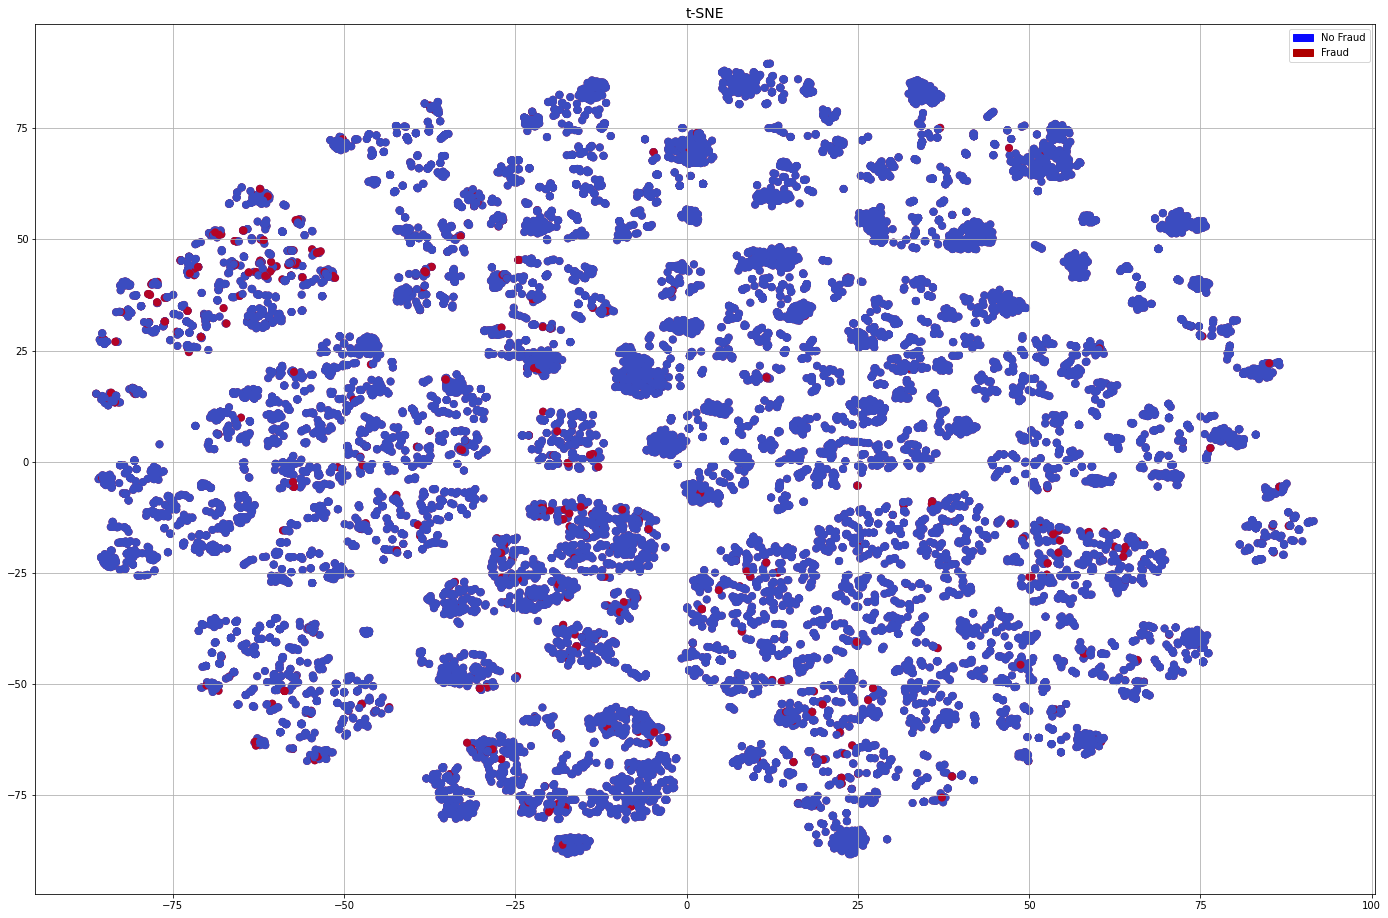

In [ ]:
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y_to_train.iloc[:20000].values == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y_to_train.iloc[:20000].values == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

# ***XGBoost***

In [ ]:
!sudo pip install --upgrade xgboost
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
	
# fit model no training data
param_dist = {'objective':'binary:logistic', 'n_estimators':5000, 'max_depth': 20,
              'learning_rate':0.1, 'alpha': 0.0005, 'gamma': 0.05,
              'eval_metric': 'auc', 'max_delta_step': 1,
              'scale_pos_weight': 33}
model = XGBClassifier(**param_dist)

In [ ]:
print(model)

XGBClassifier(alpha=0.0005, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eval_metric='auc', gamma=0.05, learning_rate=0.1,
              max_delta_step=1, max_depth=20, min_child_weight=1, missing=None,
              n_estimators=5000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=33, seed=None, silent=None,
              subsample=1, verbosity=1)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

batch_size = 115200 #32768 #115200
subset = np.floor(len(X_to_train)/batch_size).astype('int')
print("Batch_size and number of subset: ", batch_size, subset)
pre_list = []
re_list = []
f1_list = []
try:
  !mkdir models
except:
  pass

XGB_MODEL_FILE = "./models/saved_model.pkl.z"

early_stop = 10
verbose_eval = False
rounds = 50
nsplits = 8

# Model parameters
n_estimator = 6000
gamma = 0.05
max_delta_step = 1
max_depth = 30
learning_rate = 0.08


param_dist = {'booster': 'dart',
              'objective':'binary:logistic', 'n_estimators':n_estimator, 'max_depth': max_depth,
              'learning_rate':learning_rate, 'alpha': 0.0005, 'gamma': gamma,
              'eval_metric': 'auc', 'max_delta_step': max_delta_step,
              'scale_pos_weight': 33,
              'rate_drop': 0.10,
              'skip_drop': 0.5,
              'process_type': 'default'}

param_dist_new = {'booster': 'dart',
                    'objective':'binary:logistic', 'n_estimators':n_estimator, 'max_depth': max_depth,
                    'learning_rate':learning_rate, 'alpha': 0.0005, 'gamma': gamma,
                    'eval_metric': 'auc', 'max_delta_step': max_delta_step,
                    'scale_pos_weight': 33, 
                    'rate_drop': 0.10,
                    'skip_drop': 0.5,
                    'process_type': 'default'}


param_dist_update = {'booster': 'dart',
                    'objective':'binary:logistic', 'n_estimators':n_estimator, 'max_depth': max_depth,
                    'learning_rate':learning_rate, 'alpha': 0.0005, 'gamma': gamma,
                    'eval_metric': 'auc', 'max_delta_step': max_delta_step,
                    'scale_pos_weight': 33, 
                    'process_type': 'update',
                    'updater': 'refresh',
                    'refresh_leaf': True,
                    'rate_drop': 0.10,
                    'skip_drop': 0.5}


for i in range(subset+1):
  if i < subset + 1:
    X = X_to_train.iloc[batch_size*i:batch_size*(i+1)].values
    Y = Y_to_train.iloc[batch_size*i:batch_size*(i+1)].values
  else:
    X = X_to_train.iloc[batch_size*i:len(X_to_train)].values
    Y = Y_to_train.iloc[batch_size*i:len(X_to_train)].values    
  
  dtest = xgboost.DMatrix(X_test.values, label=Y_test.values)
  kf = KFold(n_splits=nsplits, random_state=None, shuffle=False)
  count = 0
  for train_index, test_index in kf.split(X):
    print("Subset and count: ", i, count)
    X_train, X_to_test = X[train_index], X[test_index]
    y_train, y_to_test = Y[train_index], Y[test_index]

    dtrain = xgboost.DMatrix(X_train, label = y_train)
    dvalid = xgboost.DMatrix(X_to_test, label = y_to_test)

    if i==0 and count==0:  
      my_model = xgboost.train(param_dist, 
                            dtrain = dtrain, 
                            num_boost_round=rounds,
                            evals=[(dvalid,'valid'), (dtrain,'train')], 
                            early_stopping_rounds=early_stop, 
                            verbose_eval=verbose_eval)
    elif i==0: # New Trees if needed
      my_model = xgboost.train(param_dist, 
                              dtrain = dtrain,
                              num_boost_round=rounds,
                              evals=[(dvalid,'valid'), (dtrain,'train')], 
                              early_stopping_rounds=early_stop, 
                              verbose_eval=verbose_eval,
                              xgb_model=XGB_MODEL_FILE)    
    else: # Update the growed tree 
      my_model = xgboost.train(param_dist_update, 
                              dtrain = dtrain,
                              num_boost_round=rounds,
                              evals=[(dvalid,'valid'), (dtrain,'train')], 
                              early_stopping_rounds=early_stop, 
                              verbose_eval=verbose_eval,
                              xgb_model=XGB_MODEL_FILE)

    my_model.save_model(XGB_MODEL_FILE)
    count += 1
    # Evaluate the performance after each subset
    predictions = (my_model.predict(dvalid)>0.5).astype('int')
    actuals = y_to_test
    tn, fp, fn, tp = confusion_matrix(actuals, predictions).ravel()

    train_predictions = (my_model.predict(dtrain)>0.5).astype('int')
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(dtrain.get_label(), train_predictions).ravel()    
    pre = tp*1.0/(tp + fp)
    re = tp*1.0/(tp + fn)
    f1 = 2.0*pre*re/(pre+re)
    pre_t = tp_t*1.0/(tp_t + fp_t)
    re_t = tp_t*1.0/(tp_t + fn_t)
    f1_t = 2.0*pre_t*re_t/(pre_t + re_t)
    print("Valid ", tn, fp, fn, tp, f1, "Train ", tn_t, fp_t, fn_t, tp_t, f1_t)

  # Evaluate the performance after each subset
  threshold_f1 = []
  threshold_pre = []
  threshold_re = []
  for threshold in range(9):
    predictions = (my_model.predict(dtest)>(threshold + 1)*0.1).astype('int')
    actuals = Y_test
    tn, fp, fn, tp = confusion_matrix(actuals, predictions).ravel()
    pre = tp*1.0/(tp + fp)
    re = tp*1.0/(tp + fn)
    f1 = 2.0*pre*re/(pre+re)
    threshold_f1.append(f1)
    threshold_pre.append(pre)
    threshold_re.append(re)
  
  print("TEST: ")
  print(threshold_f1)

  pre_list.append(threshold_pre[4])
  re_list.append(threshold_re[4])
  f1_list.append(threshold_f1[4])

Batch_size and number of subset:  115200 5
Subset and count:  0 0
Valid  13693 208 252 247 0.5178197064989517 Train  96720 554 2 3524 0.9268805891635982
Subset and count:  0 1
Valid  13847 37 33 483 0.9324324324324325 Train  97266 25 0 3509 0.9964503762601163
Subset and count:  0 2
Valid  13864 5 0 531 0.9953139643861294 Train  97298 8 0 3494 0.9988564894225271
Subset and count:  0 3
Valid  13918 0 0 482 1.0 Train  97257 0 0 3543 1.0
Subset and count:  0 4
Valid  13919 0 0 481 1.0 Train  97256 0 0 3544 1.0
Subset and count:  0 5
Valid  13904 0 0 496 1.0 Train  97271 0 0 3529 1.0
Subset and count:  0 6
Valid  13878 0 0 522 1.0 Train  97297 0 0 3503 1.0
Subset and count:  0 7
Valid  13902 0 0 498 1.0 Train  97273 0 0 3527 1.0
TEST: 
[0.38095238095238093, 0.42105263157894735, 0.43749999999999994, 0.4827586206896552, 0.5185185185185185, 0.56, 0.6086956521739131, 0.6666666666666666, 0.6666666666666665]
Subset and count:  1 0
[22:54:36] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: Y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


Subset and count:  3 0
[23:13:52] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Valid  12435 1468 141 356 0.30676432572167167 Train  87735 9433 419 3213 0.3947659417618873
Subset and count:  3 1
[23:15:04] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Valid  12432 1430 147 391 0.3314963967782959 Train  87898 9311 413 3178 0.395273631840796
Subset and count:  3 2
[23:16:16] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorr

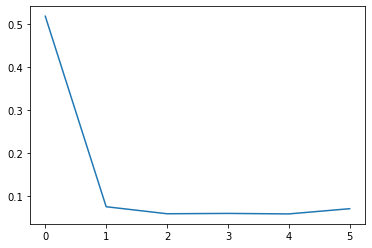

In [ ]:
plt.plot(f1_list)

In [ ]:
# Evaluation solutions
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = test_size
  dtest = xgboost.DMatrix(X_test)
  y_pred = (model.predict(dtest)>threshold).astype(int)
  
  precision = precision_cal(y_pred, y_ref)
  recall = recall_cal(y_pred, y_ref)
  
  return precision, recall, 2*precision*recall/(precision+recall)
  #return 0, 0, 0

In [ ]:
pre = []
re = []
f1 = []

pre_train = []
re_train = []
f1_train = []

new_model = xgboost.Booster({'nthread': 1})
new_model.load_model(XGB_MODEL_FILE)

threshold_value = []
indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

for i in range(90):
  threshold_value.append(0.1+i*0.01)
  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_test, Y_test, test_size=len(Y_test), threshold=threshold_value[-1])
  
  pre.append(temp_pre)
  re.append(temp_re)
  f1.append(temp_f1)

  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_to_train.iloc[indices].values, Y_to_train.iloc[indices].values, test_size=len(Y_to_train[indices]), threshold=threshold_value[-1])

  pre_train.append(temp_pre)
  re_train.append(temp_re)
  f1_train.append(temp_f1)

ValueError: ignored

In [ ]:
plt.plot(threshold_value, f1, 'b')
plt.plot(threshold_value, pre, 'r')
plt.plot(threshold_value, re, 'g')

plt.plot(threshold_value, f1_train, '--b')
plt.plot(threshold_value, pre_train, '--r')
plt.plot(threshold_value, re_train, '--g')

max_f1_indices = np.where(f1==np.max(f1))[0][0]
max_f1_train_indices = np.where(f1_train==np.max(f1_train))[0][0]
print(max_f1_indices, 0.1+max_f1_indices*0.01, 
      max_f1_train_indices, 0.1+max_f1_train_indices*0.01,
      f1[max_f1_indices],
      f1_train[max_f1_train_indices])

# ***The model using NN***

In [21]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def create_model(dense1=128, dense2=64, dense3=32, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001, bias=None):
  if bias is not None:
    bias = tf.keras.initializers.Constant(bias)
  out_model = Sequential()
  
  out_model.add(Dense(dense1,
                      input_shape=(X_to_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())
  out_model.add(Dense(dense1,
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense2,
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(1, activation="sigmoid", bias_initializer=bias))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[METRICS])
  
  return out_model

In [48]:
#my_model = create_model(dense1=256, dense2=256, dropout_rate=0.4, l1_rate=1e-4, l2_rate=5e-4, init_std=0.1, lr=0.00008)
bias = np.log([fraud_count[1][1]/fraud_count[1][0]])
my_model = create_model(dense1=512, dense2=512, dense3=128, dropout_rate=0.35, l1_rate=1e-5, l2_rate=3e-5, init_std=0.01, lr=1e-5, bias=bias)
#my_model = tf.keras.models.load_model('./best_model.h5')
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               102912    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

In [49]:
BATCH_SIZE = 1024
NB_EPOCH = 2000
PATIENCE = 10

# Class weight
total = fraud_count[1][1] + fraud_count[1][0]
weight_for_0 = (1 / fraud_count[1][0])*(total)/2.0 
weight_for_1 = (1 / fraud_count[1][1])*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=PATIENCE, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', monitor='val_auc', verbose=1, save_best_only=True,
    save_weights_only=False, mode='max')

history = my_model.fit(X_to_train, Y_to_train, verbose=0,
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.1, shuffle=True,
             callbacks=[early_stop, best_model_hold],
             class_weight=class_weight)


Epoch 00001: val_auc improved from -inf to 0.82320, saving model to ./best_model.h5

Epoch 00002: val_auc did not improve from 0.82320

Epoch 00003: val_auc improved from 0.82320 to 0.83751, saving model to ./best_model.h5

Epoch 00004: val_auc improved from 0.83751 to 0.84160, saving model to ./best_model.h5

Epoch 00005: val_auc improved from 0.84160 to 0.84480, saving model to ./best_model.h5

Epoch 00006: val_auc improved from 0.84480 to 0.84884, saving model to ./best_model.h5

Epoch 00007: val_auc improved from 0.84884 to 0.85202, saving model to ./best_model.h5

Epoch 00008: val_auc improved from 0.85202 to 0.85525, saving model to ./best_model.h5

Epoch 00009: val_auc improved from 0.85525 to 0.85694, saving model to ./best_model.h5

Epoch 00010: val_auc improved from 0.85694 to 0.85974, saving model to ./best_model.h5

Epoch 00011: val_auc improved from 0.85974 to 0.86109, saving model to ./best_model.h5

Epoch 00012: val_auc improved from 0.86109 to 0.86430, saving model to 

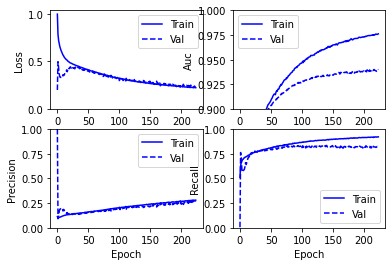

In [50]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1) 
    plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.9,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)


**F1 validation (From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)**

In [23]:
# Save model weights to drive
!cp -r best_model.h5 '/content/gdrive/My Drive/Kaggle/best_model_20200925_METRICS.h5'

#new_model = tf.keras.models.load_model('./best_model.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.3)})
new_model = tf.keras.models.load_model('./best_model.h5')
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/Kaggle/best_model_20200816_METRICS.h5')
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               102912    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

In [24]:
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.squeeze(np.argwhere(y_pred == 1), axis=1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    print
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = test_size
  y_pred = (model.predict(X_test, batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
 
  precision = precision_cal(y_pred, y_ref) + 1e-6
  recall = recall_cal(y_pred, y_ref)

  return precision, recall, 2*precision*recall/(precision+recall)

In [25]:
pre = []
re = []
f1 = []

pre_train = []
re_train = []
f1_train = []

threshold_value = []
indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

for i in range(90):
  threshold_value.append(0.1+i*0.01)
  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_test, Y_test.values, test_size=len(Y_test), threshold=threshold_value[-1])
  
  pre.append(temp_pre)
  re.append(temp_re)
  f1.append(temp_f1)

  #temp_pre, temp_re, temp_f1 = F1_score(new_model, X_to_train[indices], Y_to_train[indices], test_size=len(Y_to_train[indices]), threshold=threshold_value[-1])

  #pre_train.append(temp_pre)
  #re_train.append(temp_re)
  #f1_train.append(temp_f1)


0.7482019460687053 0.7356327333488148 0.7323236879014343 0.92


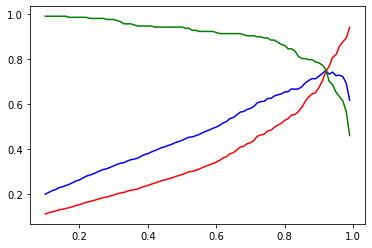

In [26]:
plt.plot(threshold_value, f1, 'b')
plt.plot(threshold_value, pre, 'r')
plt.plot(threshold_value, re, 'g')

#plt.plot(threshold_value, f1_train, '--b')
#plt.plot(threshold_value, pre_train, '--r')
#plt.plot(threshold_value, re_train, '--g')

max_f1_indices = np.where(f1==np.max(f1))[0][0]
#max_f1_train_indices = np.where(f1_train==np.max(f1_train))[0][0]
print(f1[max_f1_indices], f1[max_f1_indices-1], f1[max_f1_indices+1], threshold_value[max_f1_indices])
#print(f1_train[max_f1_train_indices], f1_train[max_f1_train_indices-1], f1_train[max_f1_train_indices+1], threshold_value[max_f1_train_indices])

In [27]:
def plot_cm(labels, predictions, p=0.5, display=True):
  cm = confusion_matrix(labels, predictions > p)
  if display:
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
  pre = cm[1][1]/(cm[1][1] + cm[0][1])
  recall = cm[1][1]/(cm[1][1] + cm[1][0])
  f1_score = 2*pre*recall/(pre+recall)
  return pre, recall, f1_score

loss :  0.22806237637996674
tp :  195.0
fp :  489.0
tn :  5210.0
fn :  12.0
accuracy :  0.9151710271835327
precision :  0.2850877046585083
recall :  0.9420289993286133
auc :  0.9784384369850159

Legitimate Transactions Detected (True Negatives):  5645
Legitimate Transactions Incorrectly Detected (False Positives):  54
Fraudulent Transactions Missed (False Negatives):  51
Fraudulent Transactions Detected (True Positives):  156
Total Fraudulent Transactions:  207


(0.7428571428571429, 0.7536231884057971, 0.748201438848921)

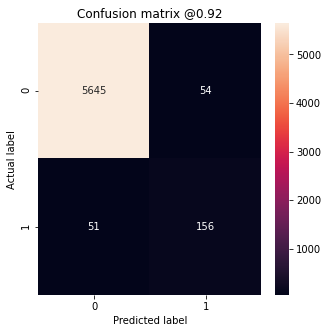

In [28]:
BATCH_SIZE = 128
baseline_results = new_model.evaluate(X_test, Y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(new_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

predictions = new_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

plot_cm(Y_test, predictions, p=threshold_value[max_f1_indices], display=True)


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,30])
  plt.ylim([70,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

train_prediction = new_model.predict(X_to_train[indices], batch_size=BATCH_SIZE, verbose=0)
plot_roc("Train Baseline", Y_to_train[indices], train_prediction, color='b')
plot_roc("Test Baseline", Y_test, predictions, color='b', linestyle='--')
plt.legend(loc='lower right')

Percentage of Fraud: 3.56% 3.5%


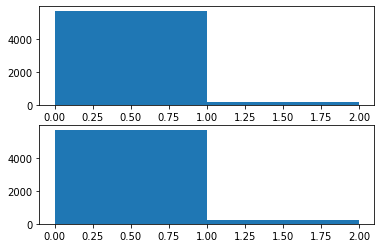

In [29]:
prediction = np.squeeze(predictions, axis=1)
threshold = threshold_value[max_f1_indices]
plt.subplot(211)
plt.hist(Y_test, bins=[0,1,2])

plt.subplot(212)
plt.hist((prediction>threshold).astype('int'), bins=[0,1,2])

fraud_predict = np.unique((prediction>threshold).astype('int'), return_counts=True)
fraud_real = np.unique(Y_test, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_predict[1][1]/np.sum(fraud_predict[1])*100,2)) + "% " + str(round(fraud_real[1][1]/np.sum(fraud_real[1])*100,2)) + "%")



# ***Auto-Encoder solution***

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
def create_model(dense1=128, dense2=64, dense3=32, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001):
  out_model = Sequential()
  
  # Input layers 1
  out_model.add(Dense(dense1, activation='tanh',
                      input_shape=(X_to_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))

  # Encoders
  out_model.add(Dense(dense2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense2/2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense2/2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  
  # Decoders
  out_model.add(Dense(dense2, activation='tanh',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(X_to_train.shape[1], activation="relu"))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='mean_squared_error',
            metrics=['accuracy'])
  
  return out_model

In [ ]:
my_model = create_model(dense1=512, dense2=128, dropout_rate=0.0, l1_rate=1e-5, l2_rate=1e-5, init_std=0.001, lr=3e-5)
my_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 512)               311808    
_________________________________________________________________
dense_36 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_40 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_41 (Dense)             (None, 608)              

In [ ]:
BATCH_SIZE = 128
NB_EPOCH = 100
PATIENCE = 5

# Class weight
'''total = fraud_count[1][1] + fraud_count[1][0]
weight_for_0 = (1 / fraud_count[1][0])*(total)/2.0 
weight_for_1 = (1 / fraud_count[1][1])*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}'''

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE, verbose=0, mode='min',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

history = my_model.fit(X_to_train, X_to_train, verbose=0,
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.01, shuffle=True,
             callbacks=[early_stop, best_model_hold])


Epoch 00001: val_loss improved from inf to 0.02892, saving model to ./best_model.h5

Epoch 00002: val_loss improved from 0.02892 to 0.02846, saving model to ./best_model.h5

Epoch 00003: val_loss improved from 0.02846 to 0.02846, saving model to ./best_model.h5

Epoch 00004: val_loss improved from 0.02846 to 0.02846, saving model to ./best_model.h5

Epoch 00005: val_loss improved from 0.02846 to 0.02846, saving model to ./best_model.h5

Epoch 00006: val_loss improved from 0.02846 to 0.02846, saving model to ./best_model.h5

Epoch 00007: val_loss did not improve from 0.02846

Epoch 00008: val_loss did not improve from 0.02846

Epoch 00009: val_loss improved from 0.02846 to 0.02846, saving model to ./best_model.h5

Epoch 00010: val_loss did not improve from 0.02846

Epoch 00011: val_loss did not improve from 0.02846

Epoch 00012: val_loss did not improve from 0.02846

Epoch 00013: val_loss did not improve from 0.02846

Epoch 00014: val_loss did not improve from 0.02846


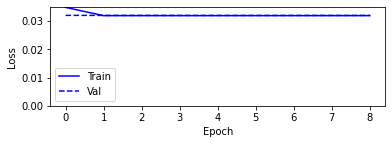

In [ ]:
def plot_metrics(history):
  metrics =  ['loss']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,1,n+1) 
    plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [ ]:
# Save model weights to drive
!cp -r best_model.h5 '/content/gdrive/My Drive/Kaggle/best_model_20200925_METRICS.h5'

#new_model = tf.keras.models.load_model('./best_model.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.3)})
new_model = tf.keras.models.load_model('./best_model.h5')
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/Kaggle/best_model_20200925_METRICS.h5')
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1024)              623616    
_________________________________________________________________
dense_24 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 608)               78432     
Total params: 866,272
Trainable params: 866,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.squeeze(np.argwhere(y_pred.values == 1), axis=1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.squeeze(np.argwhere(y_pred.values == 1), axis=1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred.values == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = test_size
  x_pred = model.predict(X_test, batch_size=128)
  mse = np.mean(np.power(X_test - x_pred, 2), axis=1)
  y_pred = (mse > threshold).astype('int')
  precision = precision_cal(y_pred, y_ref) + 1e-6
  recall = recall_cal(y_pred, y_ref)
  return precision, recall, 2*precision*recall/(precision+recall)

In [ ]:
# Test
indices = np.squeeze(np.argwhere(Y_test.values == 1), axis=1)
test_x_predictions = new_model.predict(X_test.values[indices], batch_size=128)
mse = np.mean(np.power(X_test.values[indices] - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_test.values[indices]})
error_df.describe()

,Reconstruction_error,True_class
count,20663.000000,20663.0
mean,0.037982,1.0
std,0.014638,0.0
min,0.015554,1.0
25%,0.023422,1.0
50%,0.045384,1.0
75%,0.051040,1.0
max,0.088509,1.0


In [ ]:
# Train
train_x_predictions = new_model.predict(X_test_2[:128000], batch_size=128)
mse = np.mean(np.power(X_test_2[:128000] - train_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_test_2[:128000]})
error_df.describe()

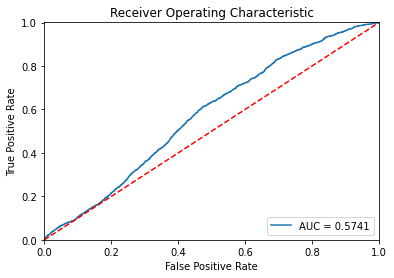

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score, precision_recall_fscore_support

fpr, tpr, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

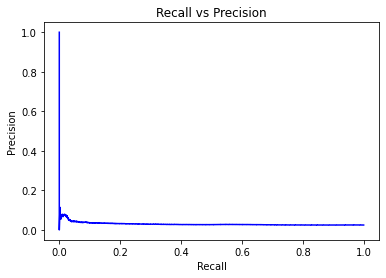

In [ ]:
precision, recall, th = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
pre = []
re = []
f1 = []

pre_train = []
re_train = []
f1_train = []

threshold_value = []

for i in range(90):
  threshold_value.append(5e-5+i*0.00001)
  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_test, Y_test.values, test_size=len(Y_test), threshold=threshold_value[-1])
  
  pre.append(temp_pre)
  re.append(temp_re)
  f1.append(temp_f1)


0.9796090283701734 0.5227718548514774 0.9765426399299002 5e-05


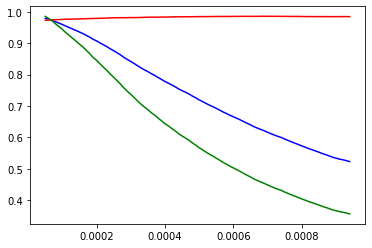

In [ ]:
plt.plot(threshold_value, f1, 'b')
plt.plot(threshold_value, pre, 'r')
plt.plot(threshold_value, re, 'g')

#plt.plot(threshold_value, f1_train, '--b')
#plt.plot(threshold_value, pre_train, '--r')
#plt.plot(threshold_value, re_train, '--g')

max_f1_indices = np.where(f1==np.max(f1))[0][0]
#max_f1_train_indices = np.where(f1_train==np.max(f1_train))[0][0]
print(f1[max_f1_indices], f1[max_f1_indices-1], f1[max_f1_indices+1], threshold_value[max_f1_indices])
#print(f1_train[max_f1_train_indices], f1_train[max_f1_train_indices-1], f1_train[max_f1_train_indices+1], threshold_value[max_f1_train_indices])

In [ ]:
def plot_cm(labels, predictions, p=0.5, display=True):
  cm = confusion_matrix(labels, predictions > p)
  if display:
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
  pre = cm[1][1]/(cm[1][1] + cm[0][1])
  recall = cm[1][1]/(cm[1][1] + cm[1][0])
  f1_score = 2*pre*recall/(pre+recall)
  return pre, recall, f1_score

loss :  0.0793645828962326
accuracy :  0.0

Legitimate Transactions Detected (True Negatives):  100842
Legitimate Transactions Incorrectly Detected (False Positives):  23994
Fraudulent Transactions Missed (False Negatives):  2400
Fraudulent Transactions Detected (True Positives):  764
Total Fraudulent Transactions:  3164


(0.030858712335406737, 0.24146649810366624, 0.05472387364801948)

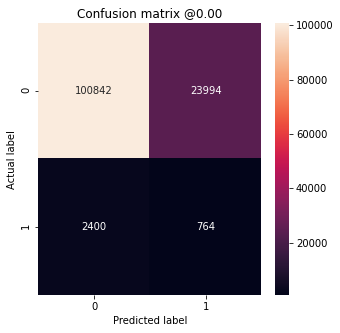

In [ ]:
BATCH_SIZE = 128
baseline_results = new_model.evaluate(X_test_2[:128000], Y_test_2[:128000],
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(new_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

predictions = new_model.predict(X_test_2[:128000], batch_size=BATCH_SIZE, verbose=0)
mse = np.mean(np.power(X_test_2[:128000] - predictions, 2), axis=1)
plot_cm(Y_test_2[:128000], mse, p=0.004761, display=True)


# ***Noise filtering and AutoEncoder***

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers import LeakyReLU
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
def create_model(dense1=128, dense2=64, dense3=32, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001):
  out_model = Sequential()
  
  # Input layers 1
  out_model.add(Dense(dense1,
                      input_shape=(X_res.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  Dropout(dropout_rate)
  BatchNormalization()

  # Encoders
  out_model.add(Dense(dense2,
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  BatchNormalization()                    
  out_model.add(Dense(dense2*2,
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  BatchNormalization()
  out_model.add(Dense(dense2,
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  Dropout(dropout_rate)
  BatchNormalization()
  
  # Decoders
  out_model.add(Dense(dense1,
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  
  # Out
  out_model.add(Dense(X_res.shape[1]))
  out_model.add(LeakyReLU(alpha=0.1))  
  Dropout(dropout_rate)
  BatchNormalization()

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='mean_squared_error',
            metrics=['accuracy', 'mse'])
  
  return out_model

In [ ]:
my_model = create_model(dense1=64, dense2=128, dropout_rate=0.4, l1_rate=1e-5, l2_rate=1e-5, init_std=0.1, lr=1e-4)
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [ ]:
# Noise adding and shuffling
X_res, Y_res = sklearn.utils.shuffle(X_res, Y_res, random_state=100)
mu, sigma = 0, 1 
X_to_train = copy.copy(X_res)
np.add(X_res, 0.5*np.random.normal(mu, sigma, X_res.shape), out=X_to_train)

array([[15.6577425 , -0.7280733 , -2.7842433 , ...,  0.43725494,
         0.7628588 ,  0.08409511],
       [ 3.8707976 , 12.078492  , -1.9180666 , ..., -0.22799064,
         0.5684519 ,  0.26365831],
       [ 5.9541044 ,  2.7137897 ,  7.76105   , ...,  0.47306597,
         0.3513357 , -0.44030944],
       ...,
       [15.217164  , -1.0908493 ,  1.70757   , ..., -0.5670386 ,
         0.33392373, -0.0480721 ],
       [13.997678  , -3.3707263 , -1.0147    , ...,  0.44594437,
         0.77031004, -0.32577595],
       [14.982988  , -2.80212   , -1.0771163 , ..., -0.59385204,
         0.45659533,  0.03677707]], dtype=float32)

In [ ]:
BATCH_SIZE = 128
NB_EPOCH = 100
PATIENCE = 5

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=PATIENCE, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=False, mode='max')

history = my_model.fit(X_to_train, X_res, verbose=0,
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.2, shuffle=True,
             callbacks=[early_stop, best_model_hold])


Epoch 00001: val_accuracy improved from -inf to 0.98367, saving model to ./best_model.h5

Epoch 00002: val_accuracy improved from 0.98367 to 0.98934, saving model to ./best_model.h5

Epoch 00003: val_accuracy improved from 0.98934 to 0.99215, saving model to ./best_model.h5

Epoch 00004: val_accuracy improved from 0.99215 to 0.99301, saving model to ./best_model.h5

Epoch 00005: val_accuracy improved from 0.99301 to 0.99434, saving model to ./best_model.h5

Epoch 00006: val_accuracy improved from 0.99434 to 0.99461, saving model to ./best_model.h5

Epoch 00007: val_accuracy did not improve from 0.99461

Epoch 00008: val_accuracy did not improve from 0.99461

Epoch 00009: val_accuracy improved from 0.99461 to 0.99536, saving model to ./best_model.h5

Epoch 00010: val_accuracy improved from 0.99536 to 0.99642, saving model to ./best_model.h5

Epoch 00011: val_accuracy did not improve from 0.99642

Epoch 00012: val_accuracy did not improve from 0.99642

Epoch 00013: val_accuracy improved

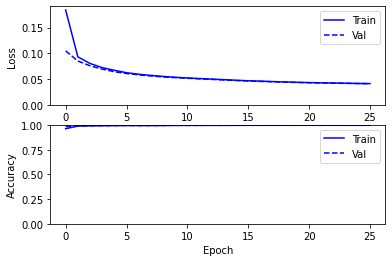

In [ ]:
def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,1,n+1) 
    plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [ ]:
# Save model weights to drive
!cp -r best_model.h5 '/content/gdrive/My Drive/Kaggle/filter_model.h5'

#new_model = tf.keras.models.load_model('./best_model.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.3)})
new_model = tf.keras.models.load_model('./best_model.h5')
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/Kaggle/filter_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [ ]:
# Test Filter and reconstruction errors
ratio = 0.2
indices = np.arange(0, X_to_train.shape[0], int(1/ratio))
test_x_predictions = new_model.predict(X_to_train[indices], batch_size=128)
mse = np.mean(np.power(X_res[indices] - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})

denoised_X_to_train = new_model.predict(X_to_train, batch_size=128)
error_df.describe()

,Reconstruction_error
count,205156.000000
mean,0.035923
std,0.020595
min,0.003378
25%,0.022457
50%,0.031411
75%,0.043956
max,0.379390


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def create_detector(dense1=128, dense2=64, dense3=32, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001, bias=None):
  if bias is not None:
    bias = tf.keras.initializers.Constant(bias)
  out_model = Sequential()
  
  out_model.add(Dense(dense1,
                      input_shape=(denoised_X_to_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  out_model.add(Dense(dense1,
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(LeakyReLU(alpha=0.1))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  '''out_model.add(Dense(dense3, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))  
  out_model.add(Dense(dense3, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())'''

  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[METRICS])
  
  return out_model

In [ ]:
detector = create_detector(dense1=64, dense2=32, dense3=16, dropout_rate=0.4, l1_rate=1e-5, l2_rate=1e-5, init_std=0.01, lr=3e-5)
detector.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                6464      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_17 (Dense)             (None, 32)               

In [ ]:
BATCH_SIZE = 256
NB_EPOCH = 300
PATIENCE = 15
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=PATIENCE, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_detector.h5', monitor='val_auc', verbose=1, save_best_only=True,
    save_weights_only=False, mode='max')

history = detector.fit(denoised_X_to_train, Y_res, verbose=1,
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.2, shuffle=True,
             callbacks=[early_stop, best_model_hold])


Epoch 1/300
3204/3206 [============================>.] - ETA: 0s - loss: 0.5715 - tp: 275656.0000 - fp: 109960.0000 - tn: 299871.0000 - fn: 134737.0000 - accuracy: 0.7017 - precision: 0.7148 - recall: 0.6717 - auc: 0.7725
Epoch 00001: val_auc improved from -inf to 0.79122, saving model to ./best_detector.h5
3206/3206 [==============================] - 33s 10ms/step - loss: 0.5715 - tp: 275788.0000 - fp: 110009.0000 - tn: 300034.0000 - fn: 134791.0000 - accuracy: 0.7017 - precision: 0.7149 - recall: 0.6717 - auc: 0.7725 - val_loss: 0.5509 - val_tp: 70991.0000 - val_fp: 27304.0000 - val_tn: 75542.0000 - val_fn: 31319.0000 - val_accuracy: 0.7143 - val_precision: 0.7222 - val_recall: 0.6939 - val_auc: 0.7912
Epoch 2/300
3205/3206 [============================>.] - ETA: 0s - loss: 0.5552 - tp: 283620.0000 - fp: 108863.0000 - tn: 301105.0000 - fn: 126892.0000 - accuracy: 0.7127 - precision: 0.7226 - recall: 0.6909 - auc: 0.7887
Epoch 00002: val_auc improved from 0.79122 to 0.79603, saving mo

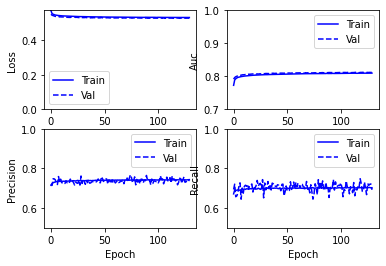

In [ ]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1) 
    plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.7,1])
    else:
      plt.ylim([0.5,1])

    plt.legend()

plot_metrics(history)

In [ ]:
# Save model weights to drive
!cp -r best_model.h5 '/content/gdrive/My Drive/Kaggle/detector_model.h5'

#new_model = tf.keras.models.load_model('./best_model.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.3)})
new_detector = tf.keras.models.load_model('./best_detector.h5')
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/Kaggle/filtrer_model.h5')
new_detector.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                6464      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_17 (Dense)             (None, 32)               

In [ ]:
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    print
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = test_size
  y_pred = (model.predict(X_test, batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
 
  precision = precision_cal(y_pred, y_ref) + 1e-6
  recall = recall_cal(y_pred, y_ref)

  return precision, recall, 2*precision*recall/(precision+recall)

def F1_check(y_pred, y_ref, threshold=0.5):
  precision = precision_cal(y_pred, y_ref) + 1e-6
  recall = recall_cal(y_pred, y_ref)
  return precision, recall, 2*precision*recall/(precision+recall)

In [ ]:
# Validation using the test set
X_test_denoised = new_model.predict(X_test, batch_size=128)
Y_predict = new_detector.predict(X_test_denoised, batch_size=128)

threshold = 0
threshold_list = []
pre_list = []
re_list = []
f1_list = []
for i in range(17):
  threshold = i*0.05 +0.1
  threshold_list.append(threshold)
  Y_result = (np.squeeze(Y_predict, axis=1) > threshold).astype('int')
  pre, re, f1 = F1_check(Y_result, Y_test.values, threshold=threshold)
  pre_list.append(pre)
  re_list.append(re)
  f1_list.append(f1)

0.32388493301153115 0.85


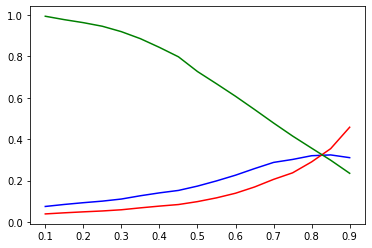

In [ ]:
plt.plot(threshold_list, f1_list, 'b')
plt.plot(threshold_list, pre_list, 'r')
plt.plot(threshold_list, re_list, 'g')

max_f1_indices = np.where(f1_list==np.max(f1_list))[0][0]
#max_f1_train_indices = np.where(f1_train==np.max(f1_train))[0][0]
print(f1_list[max_f1_indices], threshold_list[max_f1_indices])

# ***Output the result into a file for a validation with Kaggle***

In [30]:
import os
os.chdir("/content")
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv', names=saved_columns, header=0)
test_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [31]:
dataset_transaction = None
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  a = test_identity.pop(column)

to_remove_id_2 = ["TransactionDT"]
for column in to_remove_id_2:
  test_transaction.pop(column)  

In [ ]:
test_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,F,T,F,mobile
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,24.0,match_status:2,T,F,T,T,mobile
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,T,T,F,desktop
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,NaN,F,F,T,F,mobile
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,F,T,F,mobile


In [ ]:
# Remove the columns in to_remove_NaN_dataset_transaction and to_remove_NaN_dataset_identity
#for column in to_remove_NaN_dataset_transaction:
#  test_transaction.pop(column)

#for column in to_remove_NaN_dataset_identity:
#  test_identity.pop(column)

In [32]:
merged_data = pd.merge(left=test_transaction, right=test_identity, how='left', left_on='TransactionID', right_on='TransactionID')

TransactionID = merged_data.pop('TransactionID')
test_transaction = None
merged_data.shape

(506691, 427)

In [33]:
test_transaction = copy.copy(merged_data)
merged_data = None
float_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('O'))].to_list()

print(len(float_columns_test), len(int_columns_test), len(obj_columns_test))

399 1 27


In [34]:
def apply_normalization(X, indices, cache_min, cache_max, cache_mean, cache_median):
  X_out = copy.copy(X)
  #X_out[indices] = (X_out[indices] - cache_mean)/(cache_max - cache_min)
  X_out[np.where(np.isnan(X_out))[0]] = cache_median
  X_out = (X_out - cache_min)/(cache_max - cache_min)
  #X_out[np.where(np.isnan(X_out))[0]] = 0.0
  return X_out.astype('float16')  


In [35]:
for column in float_columns_test:
  # Set to float 16
  test_transaction[column].astype('float32')

  # Code the NaN feature
  test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], cache[column+'_median'])

In [36]:
for column in int_columns_test:
  # Set to int 32
  test_transaction[column].astype('int32')

  # Code the NaN feature
  test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], cache[column+'_median'])

In [37]:
encoded_column = 0
for column in obj_columns_test:
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(cache[column])
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.transform(test_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(cache[column])))])
  test_transaction = pd.concat([test_transaction, pd_encoded], axis=1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))


for column in obj_columns_test:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass

#for column in to_remove:
#  try:
#    test_transaction.pop(column)
#  except KeyError:
#    pass



Encoded columns: 207


In [41]:
# Check if we have the same shape with the X_train
print(test_transaction.shape)
#print(test_transaction.shape, np.any(np.isnan(test_transaction)))

(506691, 1007)


In [47]:
X_test_transformed = svd.transform(test_transaction)
print(X_to_train.shape, test_transaction.shape, X_test_transformed.shape)

(584841, 200) (506691, 1007) (506691, 200)


In [54]:
# Make the prediction and submit the output
#threshold = threshold_value[max_f1_indices]
threshold = 0.05
xgboost_used = False
result = np.array([])

if xgboost_used:
  batch_size = 32768 #115200
  evaluate_input = np.array(test_transaction)
  subset = np.floor(len(evaluate_input)/batch_size).astype('int')
  print("Batch_size and number of subset: ", batch_size, subset)

  for i in range(subset+1):
    print("Subset: ", i)
    if i < subset + 1:
      dvalid = xgboost.DMatrix(evaluate_input[batch_size*i:batch_size*(i+1)])
    else:
      dvalid = xgboost.DMatrix(evaluate_input[batch_size*i:len(evaluate_input)])

    if i==0:
      result = (new_model.predict(dvalid)>threshold).astype('int8')
    else:
      temp_result = (new_model.predict(dvalid)>threshold).astype('int8')
      result = np.hstack((result, temp_result))
else:
  result = (new_model.predict(X_test_transformed, batch_size=BATCH_SIZE)>threshold).astype('int8')

print(result.shape)
result_pd = pd.DataFrame(result, columns=['isFraud'])
data_to_file = pd.concat([TransactionID, result_pd], axis=1)
data_to_file.head(5)
data_to_file.to_csv("./submission.csv", index=False)
#data_to_file.to_csv('/content/gdrive/My Drive/Kaggle/submission.csv', index=False)

(506691, 1)


In [ ]:
print(result.shape, temp_result.shape)

In [55]:
!kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "New submission with model_20201008 with threshold {threshold}"

100% 4.83M/4.83M [00:03<00:00, 1.40MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [52]:
# Try with a higher threshold
threshold = threshold_value[max_f1_indices]
xgboost_used = False
result = np.array([])

if xgboost_used:
  batch_size = 32768 #115200
  evaluate_input = np.array(test_transaction)
  subset = np.floor(len(evaluate_input)/batch_size).astype('int')
  print("Batch_size and number of subset: ", batch_size, subset)

  for i in range(subset+1):
    print("Subset: ", i)
    if i < subset + 1:
      dvalid = xgboost.DMatrix(evaluate_input[batch_size*i:batch_size*(i+1)])
    else:
      dvalid = xgboost.DMatrix(evaluate_input[batch_size*i:len(evaluate_input)])

    if i==0:
      result = (new_model.predict(dvalid)>threshold).astype('int8')
    else:
      temp_result = (new_model.predict(dvalid)>threshold).astype('int8')
      result = np.hstack((result, temp_result))
else:
  result = (new_model.predict(X_test_transformed, batch_size=BATCH_SIZE)>threshold).astype('int8')

print(result.shape)
result_pd = pd.DataFrame(result, columns=['isFraud'])
data_to_file = pd.concat([TransactionID, result_pd], axis=1)
data_to_file.head(5)
data_to_file.to_csv("./submission.csv", index=False)

(506691, 1)


In [53]:
!kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "New submission with model_20200915 with threshold {threshold}"

100% 4.83M/4.83M [00:02<00:00, 2.23MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

# ***Debug zone***

In [ ]:
print(np.sum(result==[1]), np.sum(result==[1])/len(result)*100)

53593 10.577057812355065


In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
a = {'a': ['Null', 'A', 'B', 'C', 'D']}
df = pd.DataFrame(a)
df
encoded = ohc.fit_transform(df['a'].values.reshape(-1,1)).toarray()    
pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded


,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0


In [ ]:
# Check the similarity of the Object type columns
import os
import pandas as pd
import numpy as np
os.chdir("/content")
dataset_transaction = pd.read_csv('train_transaction.csv')
testset_transaction = pd.read_csv('test_transaction.csv')
#dataset_transaction = pd.read_csv('train_identity.csv')
#saved_columns = dataset_transaction.columns.to_list()
#testset_transaction = pd.read_csv('test_identity.csv', names=saved_columns, header=0)
obj_columns_data = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()
obj_columns_test = testset_transaction.columns[np.where(testset_transaction.dtypes == np.dtype('O'))].to_list()


In [ ]:
testset_transaction.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [ ]:
print(len(obj_columns_data), len(obj_columns_test), set(obj_columns_data) == set(obj_columns_test))
print(obj_columns_data)
print(obj_columns_test)
ignore_columns = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in obj_columns_data:
  data = np.unique(dataset_transaction[column].to_list())
  test = np.unique(testset_transaction[column].to_list())
  if not (set(data)==set(test)):
    print(column)
    if column not in ignore_columns:
      print(data, test)
      for each_data in test:
        if each_data not in data:
          print(each_data)
    else:
      print(column in ignore_columns)

14 14 True
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
card6
['charge card' 'credit' 'debit' 'debit or credit' 'nan'] ['charge card' 'credit' 'debit' 'nan']
P_emaildomain
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'nan' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'sud

In [ ]:
np.where(testset_transaction['P_emaildomain'] == "scranton.edu")

(array([480814, 480819]),)

In [ ]:
# Check the similarity of the Float columns
float_columns_data = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
float_columns_test = testset_transaction.columns[np.where(testset_transaction.dtypes == np.dtype('O'))].to_list()

for column in float_columns_data:
  if np.max(dataset_transaction[column]) < np.max(testset_transaction[column]):
    print(column, np.max(dataset_transaction[column]), np.max(testset_transaction[column]))

card3 231.0 232.0
C3 26.0 31.0
C5 349.0 376.0
C9 210.0 572.0
D1 640.0 641.0
D2 640.0 641.0
D3 819.0 1076.0
D4 869.0 1091.0
D5 819.0 1088.0
D6 873.0 1091.0
D7 843.0 1088.0
D8 1707.7916259765625 2029.5833740234373
D10 876.0 1091.0
D11 670.0 883.0
D12 648.0 879.0
D13 847.0 1066.0
D14 878.0 1085.0
D15 879.0 1091.0
V2 8.0 11.0
V3 9.0 11.0
V4 6.0 10.0
V5 6.0 10.0
V6 9.0 13.0
V7 9.0 13.0
V8 8.0 11.0
V9 8.0 11.0
V10 4.0 5.0
V11 5.0 7.0
V12 3.0 4.0
V15 7.0 13.0
V16 15.0 25.0
V19 7.0 13.0
V20 15.0 25.0
V23 13.0 15.0
V24 13.0 29.0
V25 7.0 13.0
V26 13.0 25.0
V27 4.0 7.0
V28 4.0 7.0
V31 7.0 13.0
V32 15.0 25.0
V33 7.0 13.0
V34 13.0 25.0
V35 3.0 4.0
V36 5.0 6.0
V39 15.0 30.0
V40 24.0 31.0
V43 8.0 11.0
V45 48.0 69.0
V46 6.0 8.0
V49 5.0 7.0
V50 5.0 7.0
V51 6.0 8.0
V54 6.0 7.0
V55 17.0 49.0
V60 16.0 17.0
V63 7.0 8.0
V64 7.0 10.0
V66 7.0 8.0
V67 8.0 10.0
V68 2.0 7.0
V70 6.0 8.0
V73 7.0 8.0
V74 8.0 10.0
V75 4.0 5.0
V76 6.0 7.0
V77 30.0 80.0
V78 31.0 80.0
V84 7.0 10.0
V85 7.0 10.0
V86 30.0 80.0
V87 30.0 80

In [ ]:
print(data, test)

['C' 'H' 'R' 'S' 'W'] ['C' 'H' 'R' 'S' 'W']


In [ ]:
b = {'a': ['Null', 'A', 'B', 'C', 'E']}
df_b = pd.DataFrame(b)
ohc_b = OneHotEncoder(handle_unknown='ignore')
ohc_b.fit(df['a'].values.reshape(-1,1))
encoded_b = ohc_b.transform(df_b['a'].values.reshape(-1,1)).toarray()    
pd_encoded_b = pd.DataFrame(encoded_b.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded_b

,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0


In [ ]:
for column in obj_columns:
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(dataset_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 5
P_emaildomain 60
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


In [ ]:
for column in obj_columns_test:
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(test_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 4
P_emaildomain 61
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


**Train val dataset**